In [1]:
import pandas as pd
import numpy as np

reaction_data = pd.read_csv('02-219-2 model fitting.csv', sep=',')
reaction_data.head()

,Unnamed: 0,Time (min),Unnamed: 2,Aldehyde,Unnamed: 4,Imine ester,Intermediate 1,Intermediate 2,Unnamed: 8,Ester fuel,...,Unnamed: 11,Unnamed: 12,Phenol waste,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Fuel dimer,Alanine waste
0,-360,0.000000,3692.28,6.000000,0.0000,0.000000,0,0,1.0,48.000000,...,0.000000,0.00,0.000000,1.0,0.000,0.000,0.000,0.00,0.000000,0.000000
1,0,6.000000,3174.99,5.484027,298.7240,0.515973,0,0,54736.6,42.980515,...,0.730489,4834.87,3.817291,84201.5,1149.700,531.518,797.085,7804.89,0.270021,3.965031
2,280,10.666667,1348.14,5.496630,123.4600,0.503370,0,0,22252.2,40.842463,...,0.944441,3119.38,5.757362,36003.9,546.197,471.279,560.055,5618.77,0.523641,6.243049
3,531,14.850000,1363.91,5.598423,97.8339,0.401577,0,0,21108.6,38.896654,...,1.129549,4111.53,7.611563,34259.3,467.696,577.954,675.183,7254.20,0.641661,8.053821
4,782,19.033333,1375.70,5.626388,91.3514,0.373612,0,0,20090.1,37.110549,...,1.265021,5003.87,9.285399,32493.1,386.847,628.454,720.433,8656.34,0.703408,9.688764


In [2]:
reaction_data.rename(columns={"Time (min)":"Time", "Ester fuel":"Fuel", "Fuel dimer":"Fuel_dimer", "Phenol waste":"Phenol_waste", "Alanine waste":"Alanine_waste", \
                             "Intermediate 1":"I1", "Intermediate 2":"I2", "Imine ester":"Imine_ester"}, inplace=True)
reaction_data.head()

,Unnamed: 0,Time,Unnamed: 2,Aldehyde,Unnamed: 4,Imine_ester,I1,I2,Unnamed: 8,Fuel,...,Unnamed: 11,Unnamed: 12,Phenol_waste,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Fuel_dimer,Alanine_waste
0,-360,0.000000,3692.28,6.000000,0.0000,0.000000,0,0,1.0,48.000000,...,0.000000,0.00,0.000000,1.0,0.000,0.000,0.000,0.00,0.000000,0.000000
1,0,6.000000,3174.99,5.484027,298.7240,0.515973,0,0,54736.6,42.980515,...,0.730489,4834.87,3.817291,84201.5,1149.700,531.518,797.085,7804.89,0.270021,3.965031
2,280,10.666667,1348.14,5.496630,123.4600,0.503370,0,0,22252.2,40.842463,...,0.944441,3119.38,5.757362,36003.9,546.197,471.279,560.055,5618.77,0.523641,6.243049
3,531,14.850000,1363.91,5.598423,97.8339,0.401577,0,0,21108.6,38.896654,...,1.129549,4111.53,7.611563,34259.3,467.696,577.954,675.183,7254.20,0.641661,8.053821
4,782,19.033333,1375.70,5.626388,91.3514,0.373612,0,0,20090.1,37.110549,...,1.265021,5003.87,9.285399,32493.1,386.847,628.454,720.433,8656.34,0.703408,9.688764


<IPython.core.display.Javascript object>


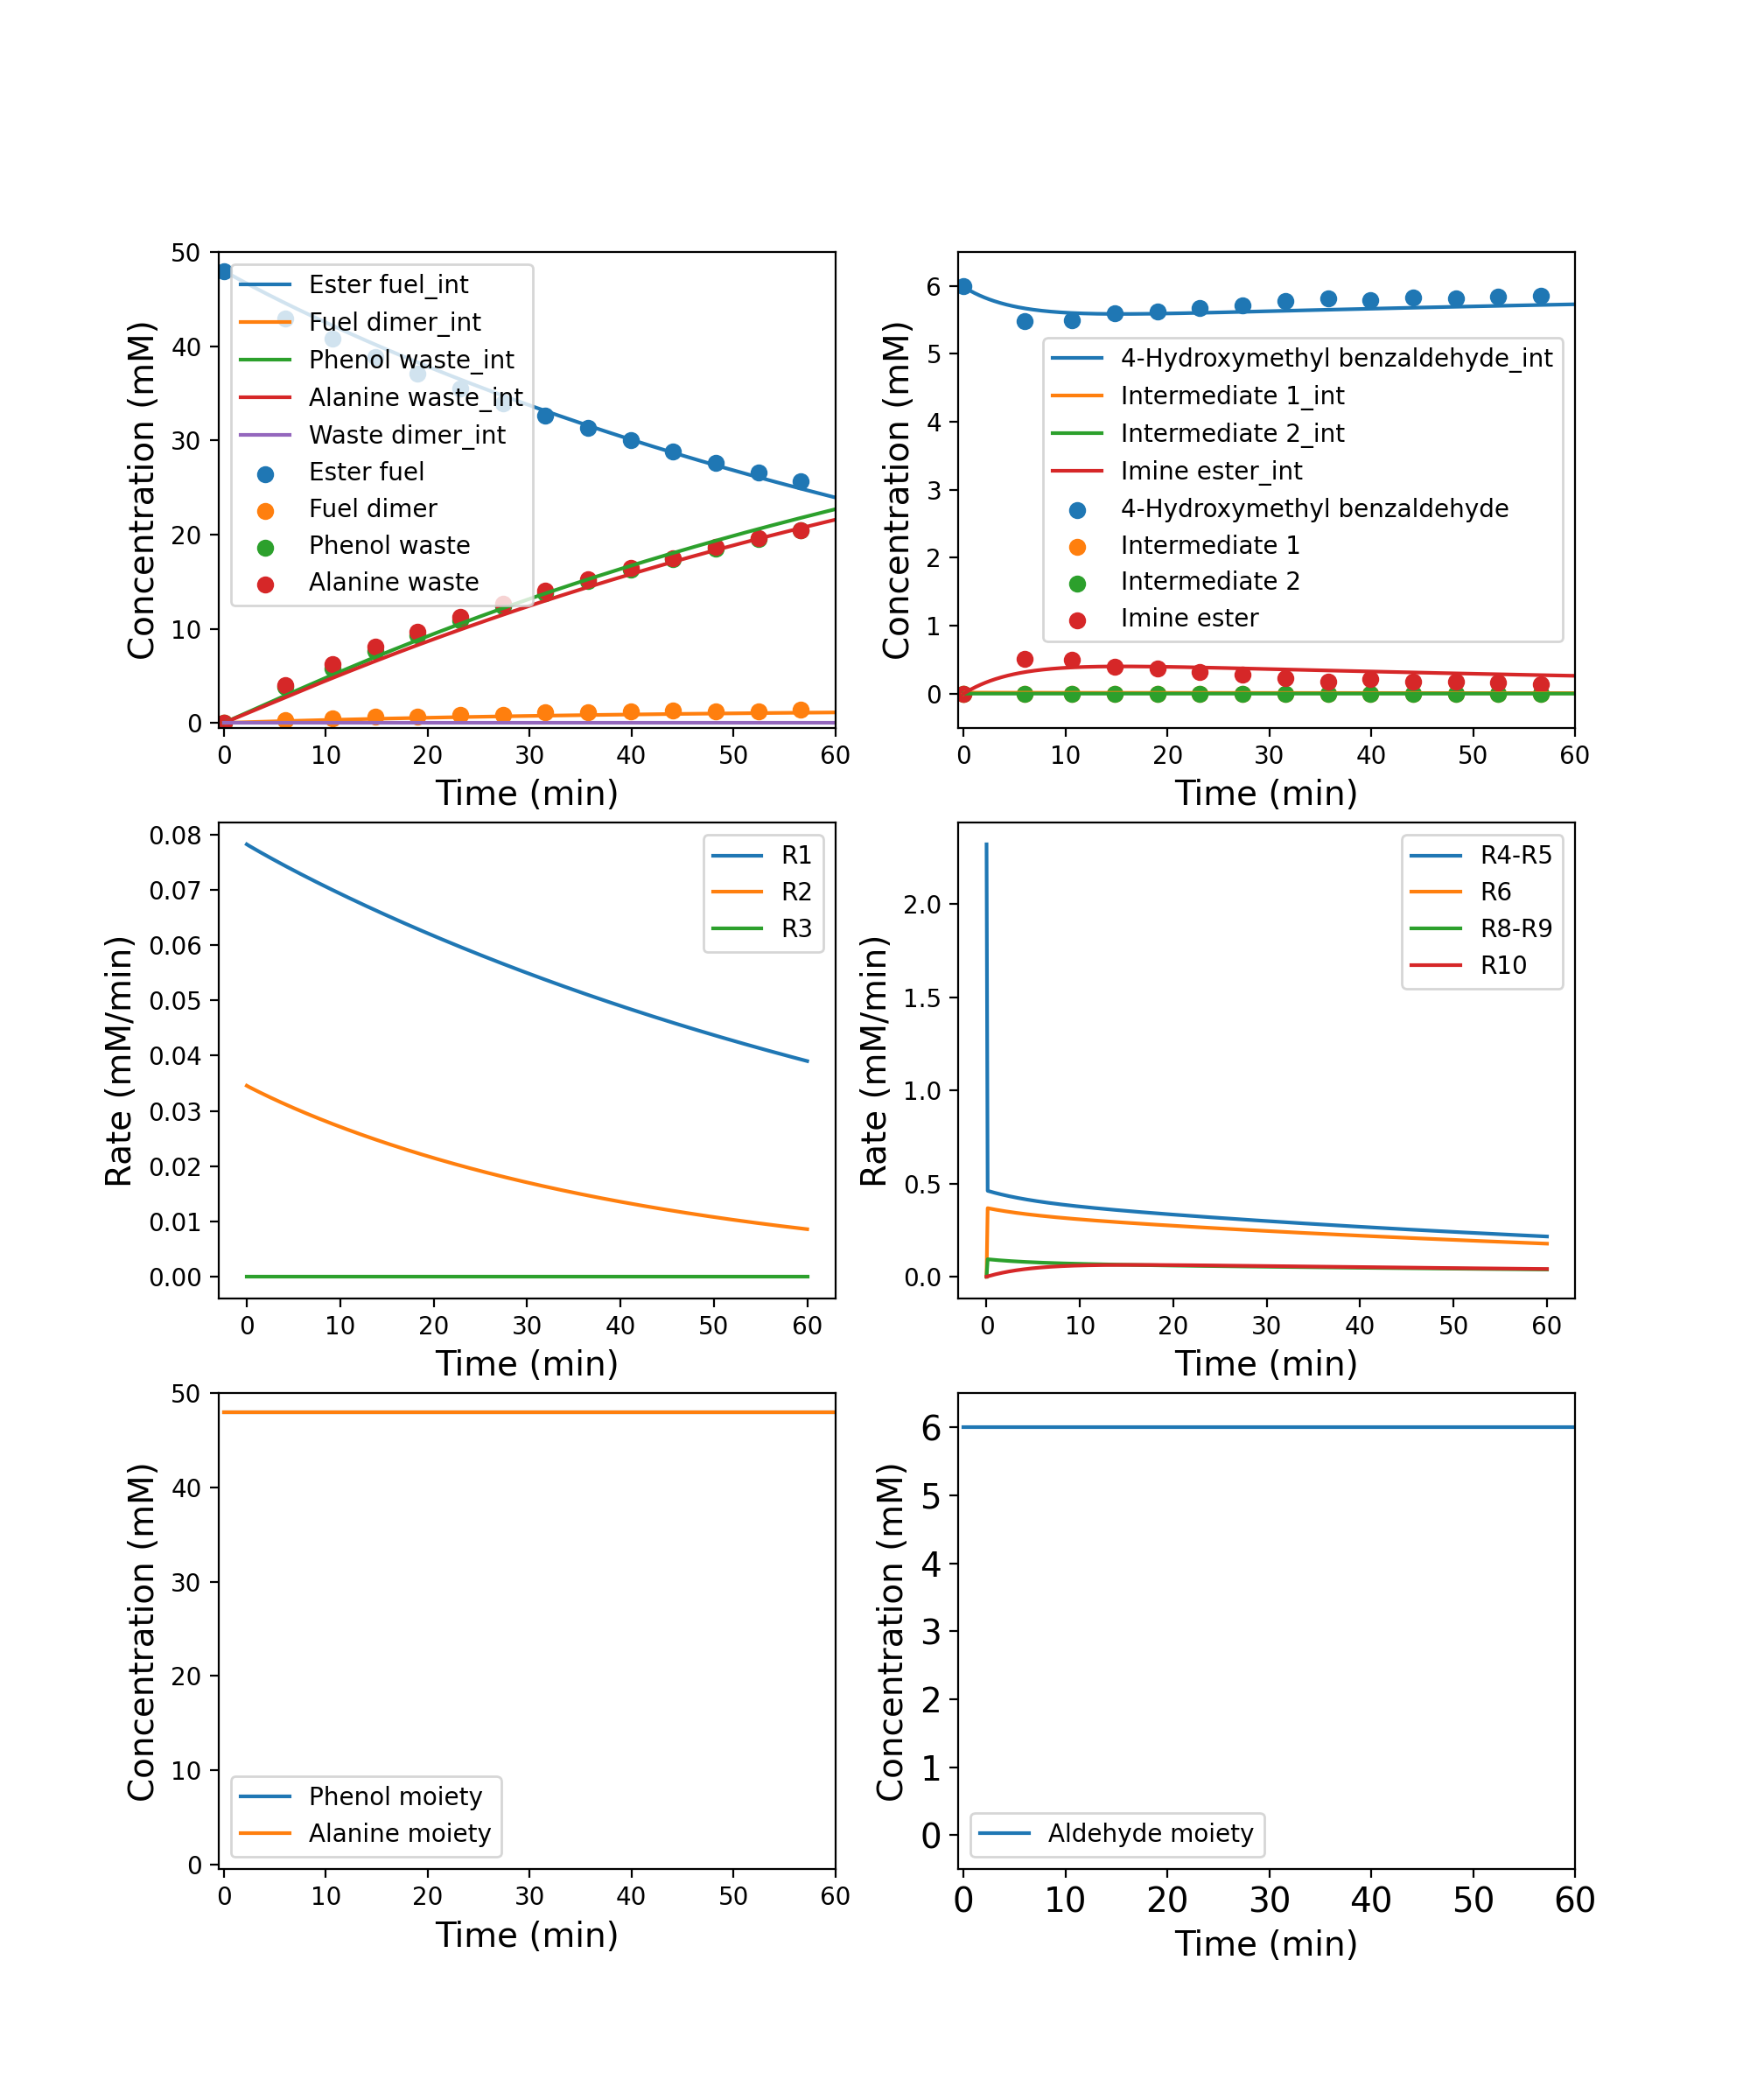

interactive(children=(FloatLogSlider(value=0.00163, description='k1', min=-6.0), FloatLogSlider(value=1.5e-05,…

In [4]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import ipywidgets as widgets
%matplotlib notebook

"""
Manual fitting to SA02-219-2 (pH 6.55) by ODE integrator. The concentration was calculated WITHOUT an external standard.

As the initial values of the rate constants, the values in Table S6 were used. The fitting was performed by combining automatic and manual fitting.

"""

t_data = np.array(reaction_data.Time, dtype=np.float64); fuel_data = np.array(reaction_data.Fuel, dtype=np.float64)
fuel_dimer_data = np.array(reaction_data.Fuel_dimer, dtype=np.float64); phenol_waste_data = np.array(reaction_data.Phenol_waste, dtype=np.float64)
alanine_waste_data = np.array(reaction_data.Alanine_waste, dtype=np.float64)
aldehyde_data = np.array(reaction_data.Aldehyde, dtype=np.float64); i1_data = np.array(reaction_data.I1, dtype=np.float64)
i2_data = np.array(reaction_data.I2, dtype=np.float64); imine_ester_data = np.array(reaction_data.Imine_ester, dtype=np.float64)

plt.ion()
fig = plt.figure(figsize=(10, 12))

def update_plot(k1,k2,k3,k4,k5,k6,k7,k8,k9,k10):
    
    #Initial concentrations
    fuel0 = 48.0; fuel_dimer0 = 0.0; phenol_waste0 = 0.0; alanine_waste0 = 0.0; waste_dimer0 = 0.0
    aldehyde0 = 6.0; i10 = 0.0; i20 = 0.0; imine_ester0 = 0.0
    
    #Time points
    t = np.linspace(0,60,501)
    
    #Calculate concentrations by numerical integration
    def rhs(C,t):
        fuel, fuel_dimer, phenol_waste, alanine_waste, waste_dimer, aldehyde, i1, i2, imine_ester = C
        return [-k1*fuel-2*k2*fuel**2-k4*fuel*aldehyde+k5*i1,
               k2*fuel**2-k3*fuel_dimer,
               k1*fuel+k2*fuel**2+k3*fuel_dimer+k6*i1+k10*imine_ester,
               k1*fuel+k7*i2+k10*imine_ester,
               k3*fuel_dimer,
               -k4*fuel*aldehyde+k5*i1+k7*i2+k10*imine_ester,
               k4*fuel*aldehyde-k5*i1-k6*i1-k8*i1+k9*imine_ester,
               k6*i1-k7*i2,
               k8*i1-k9*imine_ester-k10*imine_ester]
    
    Conc = odeint(rhs, [fuel0, fuel_dimer0, phenol_waste0, alanine_waste0, waste_dimer0, aldehyde0, i10, i20, imine_ester0], t)
    fuel_int, fuel_dimer_int, phenol_waste_int, alanine_waste_int, waste_dimer_int, aldehyde_int, i1_int, i2_int, imine_ester_int \
    = Conc[:,0], Conc[:,1], Conc[:,2], Conc[:,3], Conc[:,4], Conc[:,5], Conc[:,6], Conc[:,7], Conc[:,8]
    
    print(Conc)
    
    #Calculate rate of each reaction at each time point
    R1 = k1*fuel_int; R2 = k2*fuel_int**2; R3 = k3*fuel_dimer_int; R4 = k4*fuel_int*aldehyde_int; R5 = k5*i1_int
    R6 = k6*i1_int; R7 = k7*i2_int; R8 = k8*i1_int; R9 = k9*imine_ester_int; R10 = k10*imine_ester_int
    
    #Plot results
    plt.clf()
    ax1 = fig.add_subplot(321)
    ax2 = fig.add_subplot(322)
    ax3 = fig.add_subplot(323)
    ax4 = fig.add_subplot(324)
    ax5 = fig.add_subplot(325)
    ax6 = fig.add_subplot(326)
   
    ax1.plot(t, fuel_int, label='Ester fuel_int')
    ax1.plot(t, fuel_dimer_int, label='Fuel dimer_int')
    ax1.plot(t, phenol_waste_int, label='Phenol waste_int')
    ax1.plot(t, alanine_waste_int, label='Alanine waste_int')
    ax1.plot(t, waste_dimer_int, label='Waste dimer_int')
    
    ax1.scatter(t_data, fuel_data, label='Ester fuel')
    ax1.scatter(t_data, fuel_dimer_data, label='Fuel dimer')
    ax1.scatter(t_data, phenol_waste_data, label='Phenol waste')
    ax1.scatter(t_data, alanine_waste_data, label='Alanine waste')
    
    ax1.set_xlabel('Time (min)', fontsize=14, fontweight='normal')
    ax1.set_ylabel('Concentration (mM)', fontsize=14, fontweight='normal')
    ax1.set_xlim(-0.5, 60.0)
    ax1.set_ylim(-0.5, 50.0)
    ax1.legend(loc='best')
    
    ax2.plot(t, aldehyde_int, label='4-Hydroxymethyl benzaldehyde_int')
    ax2.plot(t, i1_int, label='Intermediate 1_int')
    ax2.plot(t, i2_int, label='Intermediate 2_int')
    ax2.plot(t, imine_ester_int, label='Imine ester_int')
    
    ax2.scatter(t_data, aldehyde_data, label='4-Hydroxymethyl benzaldehyde')
    ax2.scatter(t_data, i1_data, label='Intermediate 1')
    ax2.scatter(t_data, i2_data, label='Intermediate 2')
    ax2.scatter(t_data, imine_ester_data, label='Imine ester')

    ax2.set_xlabel('Time (min)', fontsize=14, fontweight='normal')
    ax2.set_ylabel('Concentration (mM)', fontsize=14, fontweight='normal')
    ax2.set_xlim(-0.5, 60.0)
    ax2.set_ylim(-0.5, 6.5)
    ax2.legend(loc='best')
    
    ax3.plot(t, R1, label='R1')
    ax3.plot(t, R2, label='R2')
    ax3.plot(t, R3, label='R3')
    
    ax3.set_xlabel('Time (min)', fontsize=14, fontweight='normal')
    ax3.set_ylabel('Rate (mM/min)', fontsize=14, fontweight='normal')
    ax3.legend(loc='best')
    
    ax4.plot(t, R4-R5, label='R4-R5')
    ax4.plot(t, R6, label='R6')
    ax4.plot(t, R8-R9, label='R8-R9')
    ax4.plot(t, R10, label='R10')
    
    ax4.set_xlabel('Time (min)', fontsize=14, fontweight='normal')
    ax4.set_ylabel('Rate (mM/min)', fontsize=14, fontweight='normal')
    ax4.legend(loc='best')
    
    #Check the mass balance of the phenol moiety, alanine moiety, and 4-hydroxymethyl benzaldehyde moiety
    ax5.plot(t, fuel_int+phenol_waste_int+fuel_dimer_int+i1_int+imine_ester_int, label='Phenol moiety')
    ax5.plot(t, fuel_int+alanine_waste_int+2*fuel_dimer_int+2*waste_dimer_int+i1_int+i2_int+imine_ester_int, label='Alanine moiety')
    ax5.set_xlabel('Time (min)', fontsize=14, fontweight='normal')
    ax5.set_ylabel('Concentration (mM)', fontsize=14, fontweight='normal')
    ax5.set_xlim(-0.5, 60.0)
    ax5.set_ylim(-0.5, 50.0)
    ax5.legend(loc='best')
    
    ax6.plot(t, aldehyde_int+i1_int+i2_int+imine_ester_int, label='Aldehyde moiety')
    ax6.set_xlabel('Time (min)', fontsize=14, fontweight='normal')
    ax6.set_ylabel('Concentration (mM)', fontsize=14, fontweight='normal')
    ax6.set_xlim(-0.5, 60.0)
    ax6.set_ylim(-0.5, 6.5)
    ax6.legend(loc='best')

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.show()
    fig.savefig('02-219-2  ODE integrator.svg', dpi=300, transparent=True)
    
"""
Widgets for inputting rate constants. During the adjustment, k1, k2, k3 were fixed.
"""
k1 = widgets.FloatLogSlider(min=-6, max=4, step=0.1, base=10, value=0.00163, description='k1')
k2 = widgets.FloatLogSlider(min=-6, max=4, step=0.1, base=10, value=0.000015, description='k2')
k3 = widgets.FloatLogSlider(min=-6, max=4, step=0.1, base=10, value=0.000001, description='k3')
k4 = widgets.FloatLogSlider(min=-6, max=4, step=0.1, base=10, value=0.00806, description='k4')
k5 = widgets.FloatLogSlider(min=-6, max=4, step=0.1, base=10, value=126.0, description='k5')
k6 = widgets.FloatLogSlider(min=-6, max=4, step=0.1, base=10, value=25.1, description='k6')
k7 = widgets.FloatLogSlider(min=-6, max=4, step=0.1, base=10, value=3230.0, description='k7')
k8 = widgets.FloatLogSlider(min=-6, max=4, step=0.1, base=10, value=6.4, description='k8')
k9 = widgets.FloatLogSlider(min=-6, max=4, step=0.1, base=10, value=0.0251, description='k9')
k10 = widgets.FloatLogSlider(min=-6, max=4, step=0.1, base=10, value=0.158, description='k10')

widgets.interactive(update_plot, k1=k1, k2=k2, k3=k3, k4=k4, k5=k5, k6=k6, k7=k7, k8=k8, k9=k9, k10=k10)